In [1]:
import torch

In [2]:

if torch.backends.mps.is_available():
    torch_device = torch.device("mps")
    x = torch.ones(1, device=torch_device)
    print (x)
else:
    torch_device = torch.device("cpu")
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## Module

In [3]:
import torch.nn as nn

EMBEDDING_DIM = 3
CONTEXT_LENGTH = 4
QKV_DIM = 2

class CausalSelfAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length=CONTEXT_LENGTH, dropout=0.5, qkv_bias=False):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.w_q = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_k = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_v = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.dropout = nn.Dropout(dropout).to(torch_device)
        self.register_buffer(
            'mask', 
            torch.triu(
                torch.ones(context_length, context_length), 
                diagonal=1,
            ).to(torch_device)
        )

    def forward(self, x):
        num_tokens = x.shape[-2]
        queries = self.w_q(x)
        keys = self.w_k(x)
        attn_scores = queries @ keys.transpose(-2, -1)
        causal_attn_scores = attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        causal_attn_weights = torch.softmax(causal_attn_scores*(self.d_out**0.5), dim=-1)
        causal_attn_weights = self.dropout(causal_attn_weights)
        values = self.w_v(x)
        context = causal_attn_weights @ values
        return context

In [4]:
csa = CausalSelfAttention(EMBEDDING_DIM, QKV_DIM)
input_embeddings = torch.randn(8, CONTEXT_LENGTH, EMBEDDING_DIM).to(torch_device)/(EMBEDDING_DIM**0.5)
context = csa(input_embeddings)
context[0]

tensor([[ 0.0000,  0.0000],
        [-0.4278,  0.1266],
        [ 0.1237, -0.0327],
        [ 0.3470, -0.5853]], device='mps:0', grad_fn=<SelectBackward0>)

In [5]:
import torch.nn as nn

EMBEDDING_DIM = 3
CONTEXT_LENGTH = 4
QKV_DIM = 2

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = d_out//num_heads
        self.w_q = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_k = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_v = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_o = nn.Linear(d_out, d_out).to(torch_device)
        self.dropout = nn.Dropout(dropout).to(torch_device)
        self.register_buffer(
            'mask', 
            torch.triu(
                torch.ones(context_length, context_length), 
                diagonal=1,
            ).to(torch_device)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.w_k(x)
        queries = self.w_q(x)
        values = self.w_v(x)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(-3, -2)
        # TODO: KV Cache Optimization
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(-3, -2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(-3, -2)
        attn_scores = queries @ keys.transpose(-2, -1)
        causal_attn_scores = attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        causal_attn_weights = torch.softmax(causal_attn_scores*(keys.shape[-1]**0.5), dim=-1)
        causal_attn_weights = self.dropout(causal_attn_weights)
        context = (causal_attn_weights @ values).transpose(-3, -2)
        context = context.contiguous().view(b, num_tokens, self.num_heads*self.head_dim)
        context = self.w_o(context)
        return context


In [6]:
EMBEDDING_DIM = 3
CONTEXT_LENGTH = 4
QKV_DIM = 4

mha = MultiHeadAttention(EMBEDDING_DIM, QKV_DIM, CONTEXT_LENGTH, 0.5, 2)
context = mha(input_embeddings)
context.shape

torch.Size([8, 4, 4])

## Model

In [7]:
import torch
from torch import nn

In [8]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(d_model))
        self.shift = nn.Parameter(torch.zeros(d_model))

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True, unbiased=False)
        x = (self.scale * (x - mean) / (std + self.eps)) + self.shift
        return x

In [10]:
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0/torch.pi, device=torch_device)) * (x  + 0.044715 * x**3)
            )
        )

In [14]:
x = torch.linspace(-3, 3, 100).to(torch_device)
gelu = GELU()
y = gelu(x)

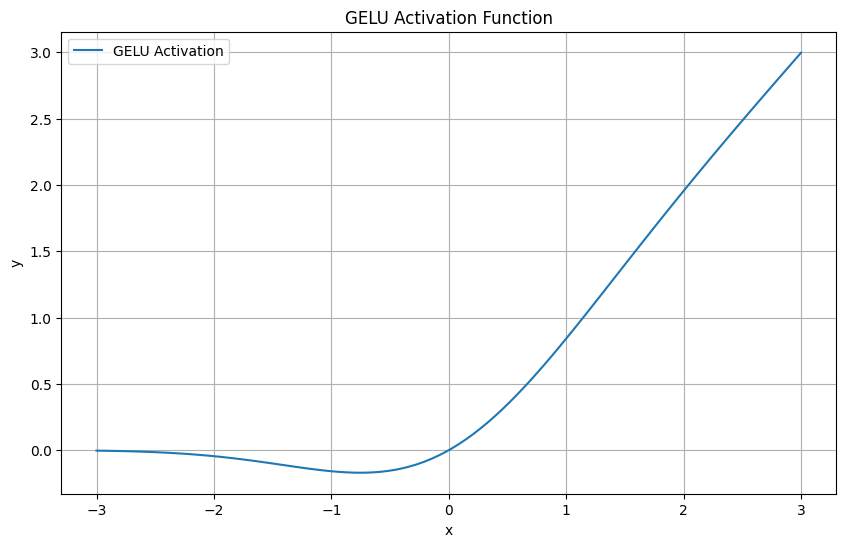

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x.cpu().numpy(), y.cpu().detach().numpy(), label='GELU Activation')
plt.xlabel('x')
plt.ylabel('y')
plt.title('GELU Activation Function')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
class FeedForward (nn.Module):
    def __init__(self, cfg): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"]*4).to(torch_device),
            GELU().to(torch_device),
            nn.Linear(cfg["emb_dim"]*4, cfg["emb_dim"]).to(torch_device),
        )

    def forward(self, x):
        return self.layers(x)

In [20]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768).to(torch_device)
out = ffn(x)
out.shape

torch.Size([2, 3, 768])

In [33]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config["emb_dim"]).to(torch_device)
        self.attn = MultiHeadAttention(config["emb_dim"], config["emb_dim"], config["context_length"], config["drop_rate"], config["n_heads"], config["qkv_bias"]).to(torch_device)
        self.drop = nn.Dropout(config["drop_rate"]).to(torch_device)
        self.ln2 = nn.LayerNorm(config["emb_dim"]).to(torch_device)
        self.ff = FeedForward(config).to(torch_device)

    def forward(self, x):
        x = self.drop(self.attn(self.ln1(x))) + x
        x = self.drop(self.ff(self.ln2(x))) + x
        return x

In [37]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]).to(torch_device)
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]).to(torch_device)
        self.drop_emb = nn.Dropout(cfg["drop_rate"]).to(torch_device)
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        ).to(torch_device)
        self.final_norm = LayerNorm(cfg["emb_dim"]).to(torch_device)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False).to(torch_device)

    def forward(self, in_idx):
        in_idx = in_idx.to(torch_device)
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=torch_device))
        x = self.drop_emb(tok_embeds + pos_embeds)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [38]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
tokenizer = tiktoken.get_encoding("gpt2")

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)
        token_ids = token_ids
        token_ids = torch.tensor(token_ids).to(torch_device)
        token_sequences = token_ids.unfold(0, max_length, stride)
        self.input_ids = token_sequences[:-1]
        self.target_ids = token_sequences[1:]

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(
        txt, batch_size=4, max_length=256, 
        stride=128, shuffle=True, drop_last=True,
        num_workers=0,
    ):
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
        drop_last=drop_last,
    )

with open("../../data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

dataloader = create_dataloader_v1(raw_text[50:], batch_size=8, max_length=GPT_CONFIG_124M["context_length"], stride=2, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  268,  3754,   438,  ...,   286,   262,  7877],
        [  438,  2016,   257,  ...,  7877,    72,  3150],
        [  257,   922,  5891,  ...,  3150,   339,  8104],
        ...,
        [  340,   373,   645,  ..., 37918,   411,   290],
        [  645,  1049,  5975,  ...,   290,  8465,   286],
        [ 5975,   284,   502,  ...,   286,   281, 33954]], device='mps:0'), tensor([[  438,  2016,   257,  ...,  7877,    72,  3150],
        [  257,   922,  5891,  ...,  3150,   339,  8104],
        [ 5891,  1576,   438,  ...,  8104,   866,  1973],
        ...,
        [  645,  1049,  5975,  ...,   290,  8465,   286],
        [ 5975,   284,   502,  ...,   286,   281, 33954],
        [  502,   284,  3285,  ..., 33954,   271,  3973]], device='mps:0')]


In [39]:
gpt = DummyGPTModel(GPT_CONFIG_124M)
gpt(first_batch[0])

tensor([[[ 0.1262,  0.0891,  0.5763,  ...,  0.0204, -0.2858, -0.5722],
         [-0.5513, -0.4048,  1.3528,  ...,  0.2848, -0.4136,  0.1375],
         [ 0.7228,  0.1680, -0.3502,  ..., -1.0963,  0.0880,  1.0310],
         ...,
         [-0.3543, -1.2870,  0.5911,  ..., -0.2834, -0.1321,  0.1746],
         [ 0.1739,  0.2213, -1.9957,  ...,  0.4184,  0.5599,  1.9302],
         [ 0.0610,  0.2478,  1.1949,  ...,  0.4700,  1.1792, -0.6527]],

        [[ 0.4774,  0.2370,  0.1052,  ...,  0.2165, -0.8574,  0.4955],
         [-0.4754,  1.0396,  1.5438,  ...,  0.5923,  0.1351,  0.4887],
         [ 0.9107, -0.1868, -0.3470,  ..., -0.5047, -1.2149,  0.1710],
         ...,
         [-0.8525, -1.3352,  1.8167,  ..., -0.4199,  1.2835,  0.0412],
         [ 1.1149, -0.0914, -0.7332,  ..., -0.9261,  1.0550,  1.3011],
         [ 1.9892, -0.7033,  0.0369,  ..., -0.2974, -0.0111,  0.1645]],

        [[ 0.4093, -0.0050, -0.1816,  ...,  1.6179, -2.2207, -0.5701],
         [-0.7639, -0.0053,  1.6686,  ...,  1